In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)

In [2]:
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2023-01-01"
TO = "2025-05-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "FTSE 100"
WINDOW = 7
EPOCHS = 200

In [3]:
# Define news search keywords
keywords = {
    "FTSE 100",
    "inflation",
    "interest rates",
    "economic growth",
    "recession",
    "unemployment",
    "tariffs",
    "stimulus",
    "investment",
    "expansion"
}

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews

# Fetch news data function
def fetch_ftse_news_data():
    gn = GoogleNews(lang="en", country="UK")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ftse_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")


Loaded 12163 news articles


In [6]:
import yfinance

# Fetch FTSE 100 market data using yfinance
ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ftse100_data = ftse100_data.reset_index()  # Convert index to column
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna().reset_index(drop=True)

print(f"Loaded {len(ftse100_data)} days of FTSE 100 market data")

Loaded 587 days of FTSE 100 market data


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Computing sentiment predictions from scratch...
Processing 12163 news titles in batches of 32
Computed and cached sentiment predictions for 852 dates
Plotting sentiment distribution...


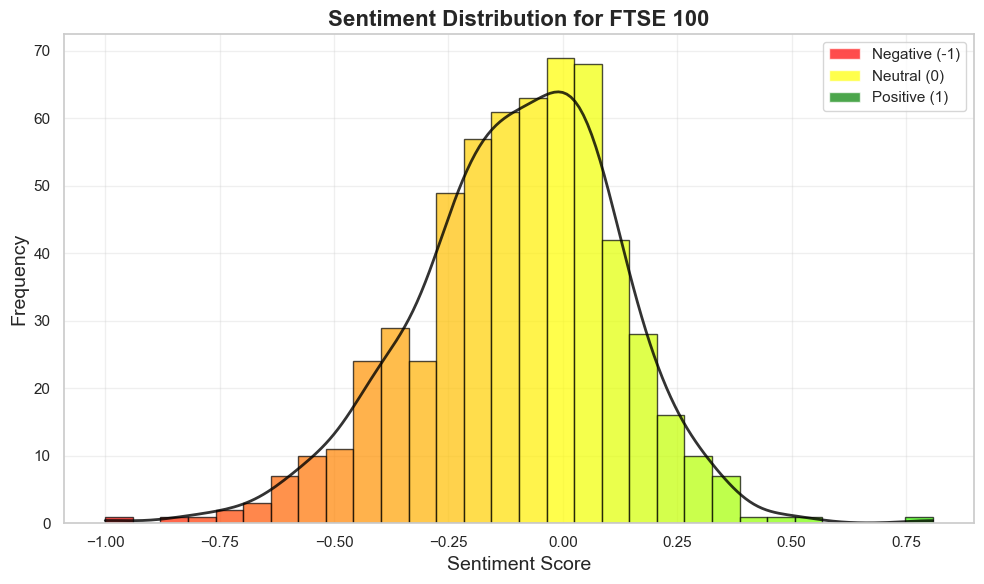

Final feature columns for model: ['Volatility_Smooth', 'sentiment_vol', 'sentiment_mean_5d', 'sentiment_std_5d', 'sentiment_std_7d', 'sentiment_vol_interaction']


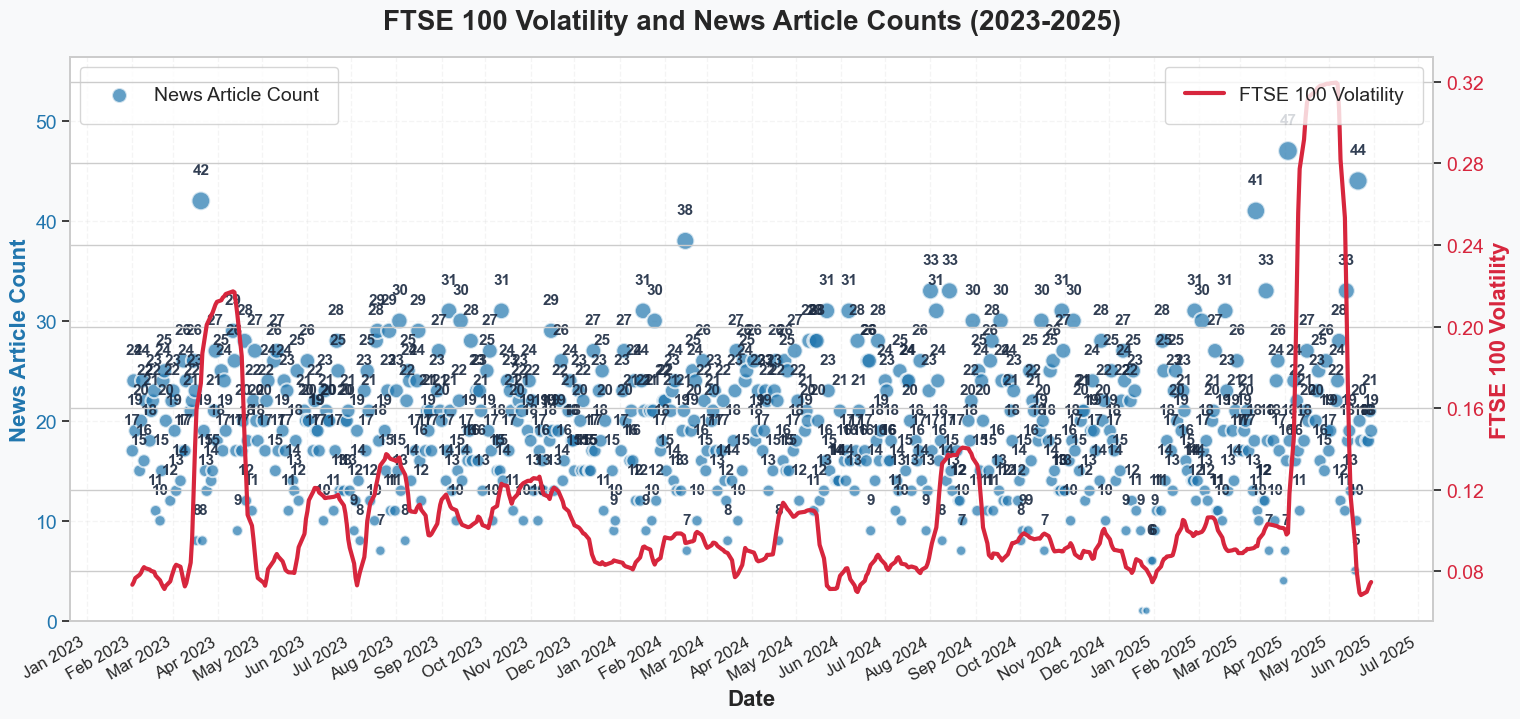

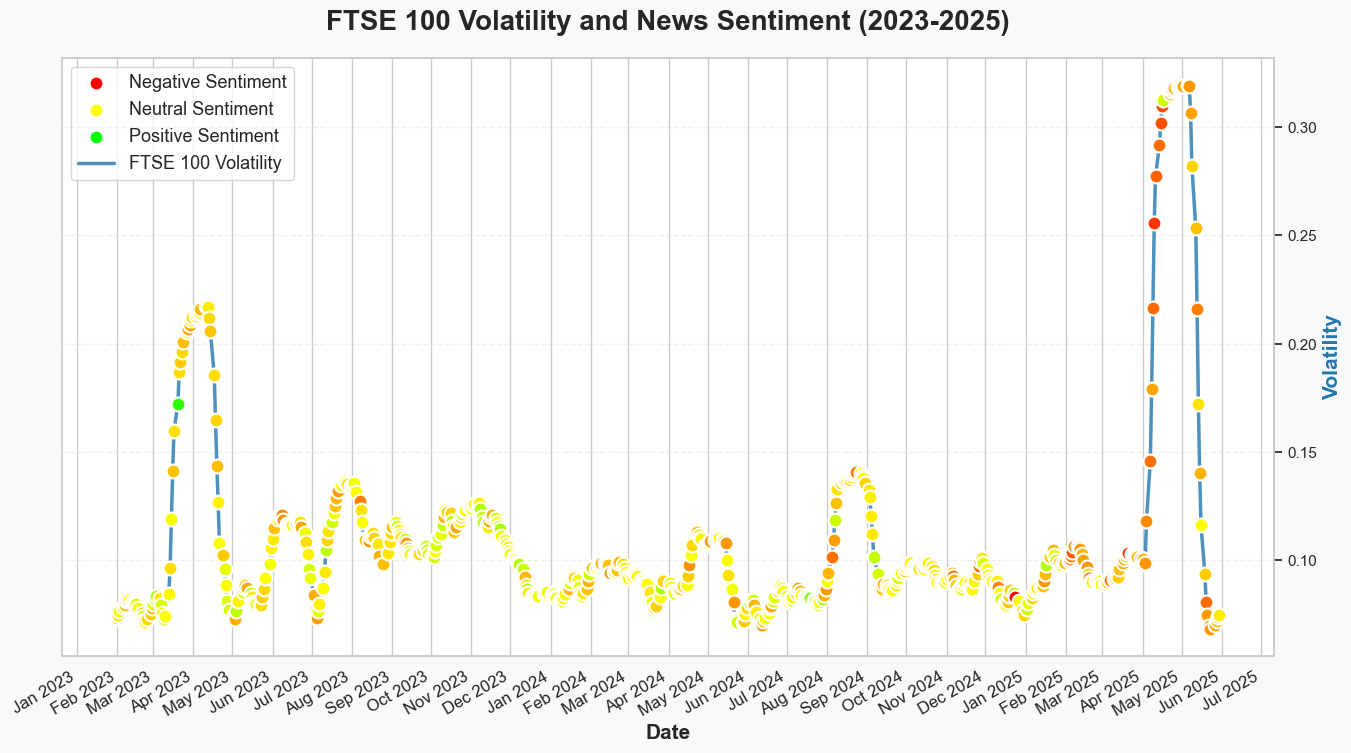

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.13752, Val Loss: 0.03272
Epoch 10/200, Train Loss: 0.00923, Val Loss: 0.00428
Epoch 20/200, Train Loss: 0.00548, Val Loss: 0.00264
Epoch 30/200, Train Loss: 0.00360, Val Loss: 0.00194
Epoch 40/200, Train Loss: 0.00231, Val Loss: 0.00131
Epoch 50/200, Train Loss: 0.00162, Val Loss: 0.00091
Epoch 60/200, Train Loss: 0.00132, Val Loss: 0.00080
Epoch 70/200, Train Loss: 0.00115, Val Loss: 0.00075
Epoch 80/200, Train Loss: 0.00103, Val Loss: 0.00070
Epoch 90/200, Train Loss: 0.00094, Val Loss: 0.00065
Epoch 100/200, Train Loss: 0.00085, Val Loss: 0.00060
Epoch 110/200, Train Loss: 0.00079, Val Loss: 0.00056
Epoch 120/200, Train Loss: 0.00073, Val Loss: 0.00052
Epoch 130/200, Train Loss: 0.00068, Val Loss: 0.00049
Epoch 140/200, Train Loss: 0.00063, Val Loss: 0.00046
Epoch 150/200, Train Loss: 0.00060, Val Loss: 0.00044
Epoch 160/200

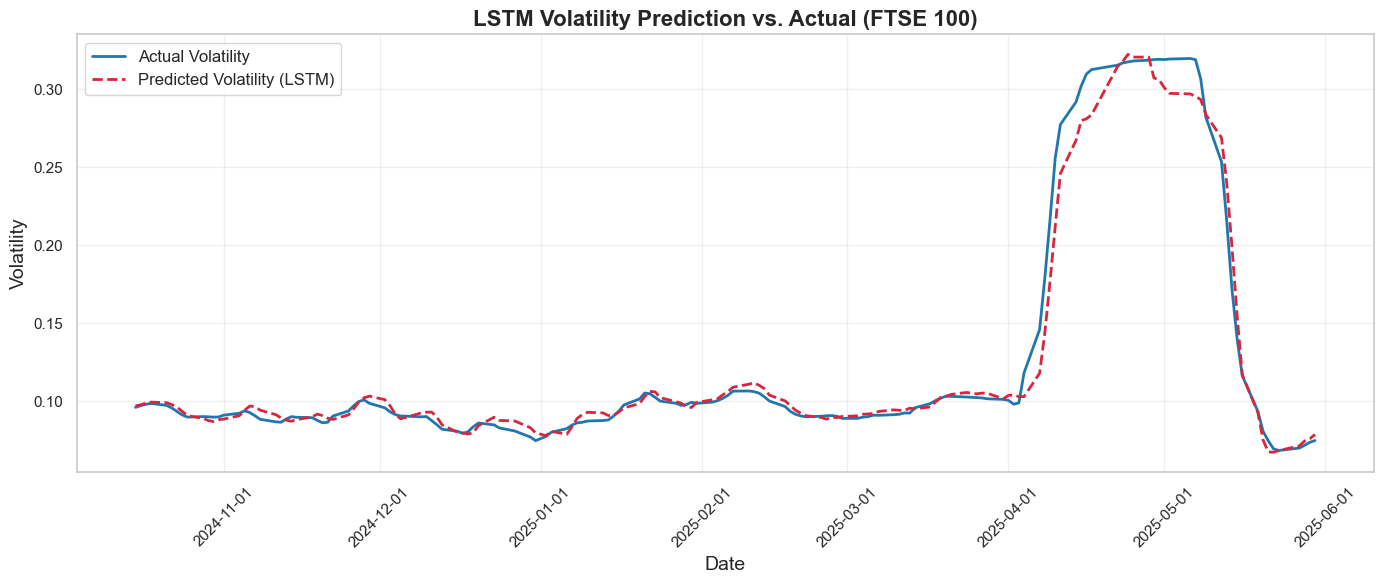

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    epochs=EPOCHS,
)